# Ensembles

For this data we're going to go back to the MLB and our pitch prediction task.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import zipfile

# Read in our data
#filename="assets/baseball_svm_data.zip"
df=pd.read_csv("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\IntroductiontoMachineLearninginSportsAnalytics\\data\\reg_Sep2019.csv")

# Setup the features
pitch_metrics=['release_spin_rate','release_extension','release_pos_y','release_pos_x','release_pos_z','effective_speed']
player_metrics=['player_name']
game_details=['outs_when_up','inning']
features=[*pitch_metrics, *player_metrics, *game_details]

# Clean as before
df=df.dropna(subset=["pitch_type"])
df=df[df["pitch_type"]!="EP"]
df['player_name']=df['player_name'].factorize()[0]
df['pitch_numeric']=df['pitch_type'].factorize()[0]
df=df[[*features, "pitch_numeric", "pitch_type"]]

In [3]:
# Now, let's create our training and validation sets. This time I'm going 
# to stratify our sample across the different kinds of pitches which
# exist.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df[features],
                                                  df["pitch_numeric"],
                                                  train_size=0.1,
                                                  random_state=1337, 
                                                  stratify=df["pitch_numeric"])

# Then we can fill missing values with the mean. Remember two things when doing this:
# (a) choosing the mean is an arbitrary choice on my part! It might not make sense always!
# (b) you *must* do this *after* you split your training/validation sets, these two
# datasets must be treated as independent
X_train=X_train.fillna(X_train.mean())
X_val=X_val.fillna(X_val.mean())

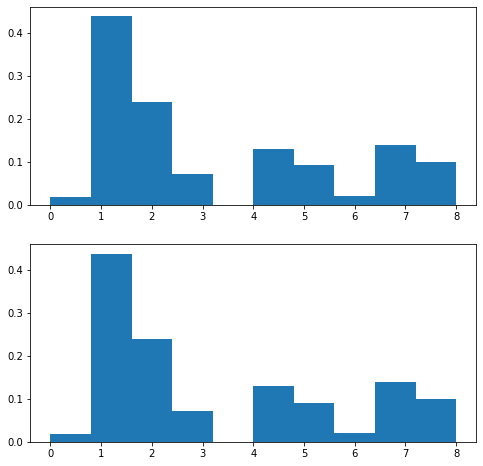

In [4]:
# We can verify that these are correctly stratified by looking at at the histograms
# of each, they should look the same as proportions
fig, axes = plt.subplots(2, figsize=(8,8))
axes[0].hist(y_train, density=True)
axes[1].hist(y_val, density=True);

# Voting Classifier
So let's look at a voting classifier first. This is just a majority vote of the models which we have trained.

In [5]:
# So we import our ensemble classifier
from sklearn.ensemble import VotingClassifier

# The nice thing with ensembles is the very first argument is some list of
# estimators (classifiers) - so all we really have to do is put together a
# dictonary of classifiers we want to use!
clfs={}

# Let's create a couple of different of descision trees
from sklearn.tree import DecisionTreeClassifier

# - one which has only a depth of 3
clfs["dt0"]=DecisionTreeClassifier(max_depth=3, random_state=1337)
# - one which requires there to be at least 7 samples at each leaf
clfs["dt1"]=DecisionTreeClassifier(min_samples_leaf=7, random_state=1337)
# - and one which balances the classes since we have unbalanced data
clfs["dt2"]=DecisionTreeClassifier(class_weight="balanced", random_state=1337)

In [6]:
# Ensembles are just another classifier, but many of the ensembles, like
# voting ensembles, can do work in parallel. Here I'm setting the n_jobs
# parameter to -1, which tells the classifier to use all system CPUs
voters=VotingClassifier(estimators=clfs.items(), n_jobs=-1)

# And then we just fit the data
voters.fit(X_train,y_train)

VotingClassifier(estimators=dict_items([('dt0', DecisionTreeClassifier(max_depth=3, random_state=1337)), ('dt1', DecisionTreeClassifier(min_samples_leaf=7, random_state=1337)), ('dt2', DecisionTreeClassifier(class_weight='balanced', random_state=1337))]),
                 n_jobs=-1)

In [7]:
# So now the voters variable is this collection of three different 
# models which have been trained on this dataset, and we can do things 
# like look at the accuracy or other evaluation measures
voters.score(X_train, y_train)

0.8426713356678339

In [8]:
# Of course, we're interested in performance in our validation dataset
# so we can look at that too
voters.score(X_val, y_val)

0.6687968880244513

You can see here that our training data accuracy score is much higher than our validation accuracy score. This is to be expected -- all of the previous comments about using cross fold validation to improve your understanding of the accuracy, or not using accuracy at all and instead looking at something like a confusion matrix, those all still apply. But instead of tuning this more, I want to move on to our next ensemble technique.

# Bagging Classifier
Recall that the bagging approach to ensembles creates a number of different classifiers but does so from a single model and acts more like cross validation, pulling out random subsets of data.

In [9]:
from sklearn.ensemble import BaggingClassifier

# In this approach we only have one model definition so let's use one of 
# our descision trees. We can set how many classifiers we want the bagger
# to use, as well using the n_estimators parameter. There are many other
# parameters to use, I'll use one here which sets the maximum number of
# features each classifier in the bag can use at 70%
bagger=BaggingClassifier(base_estimator=clfs["dt0"],
                        n_estimators=10,
                        max_features=0.7,
                        n_jobs=-1,
                        random_state=1337)
bagger.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=1337),
                  max_features=0.7, n_jobs=-1, random_state=1337)

In [10]:
# With the bagger and the voter we can actually explore the individual models 
# which have been created using the estimators_ attribute
bagger.estimators_

[DecisionTreeClassifier(max_depth=3, random_state=1877400054),
 DecisionTreeClassifier(max_depth=3, random_state=1648446500),
 DecisionTreeClassifier(max_depth=3, random_state=1450094261),
 DecisionTreeClassifier(max_depth=3, random_state=112011887),
 DecisionTreeClassifier(max_depth=3, random_state=1594782299),
 DecisionTreeClassifier(max_depth=3, random_state=1826879162),
 DecisionTreeClassifier(max_depth=3, random_state=1995803259),
 DecisionTreeClassifier(max_depth=3, random_state=83361002),
 DecisionTreeClassifier(max_depth=3, random_state=969459084),
 DecisionTreeClassifier(max_depth=3, random_state=284273109)]

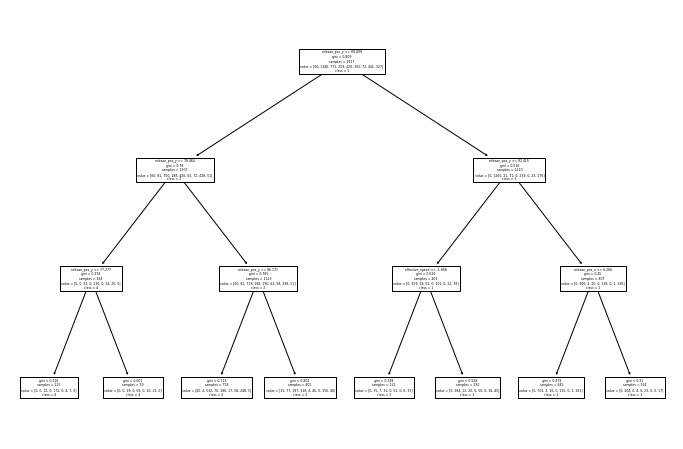

In [11]:
# You can see that the only difference in the parameterization of the
# individual classifier models is the random state.

# Since they are all just regular descision trees underneath, we could
# do anything we wanted to to the trees, including plotting them

from sklearn.tree import plot_tree
fig= plt.figure(figsize=(12,8))
plot_tree(bagger.estimators_[0], 
          feature_names=X_train.columns, 
          class_names=np.unique(y_train.astype(str)));
plt.savefig('tree.svg',bbox_inches = "tight")

In [12]:
# We can of course look at the score of the bagger both on training data
bagger.score(X_train, y_train)

0.6388194097048524

In [13]:
# And on our validation data
bagger.score(X_val, y_val)

0.6248958043901084

# Boosting Ensemble
With boosting our goal is to build an additive model, where our second model builds on the first, then the third model builds on both of those, and so forth. There are various algorithms which can be used to do this, and a common approach in sklearn is to use the `GradientBoostingClassifier`. This method doesn't take a model to use, instead it uses a series of it's own regression trees directly.

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Since this is a tree, we can select various tree parameters. Again, 
# we can set the n_estimators parameter to determine how many, as
# a maximum, trees should be built. You'll notice that there is no
# parameter for the number of CPUs -- this approach is a serial one
# so you can't easily parallelize this unless you want to train
# multiple boosters and ensemble them together
booster=GradientBoostingClassifier(min_samples_leaf=7, 
                                   max_depth=5, 
                                   n_estimators=100, 
                                   random_state=1337)

booster.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=7, random_state=1337)

In [15]:
# Once the booster is done we can see how many models it
# ended up generating
booster.n_estimators

100

In [16]:
# And like all of our classifiers, we can see the score on the training set
booster.score(X_train, y_train)

0.9819909954977488

In [17]:
# And on our validation data
bagger.score(X_val, y_val)

0.6248958043901084

# Stacking Ensemble
Metalearning consists of using a number of different models and learning which one is best. You can think of this as surveying the talking heads on TV as to who they think is going to perform the best, then learning over time which one to weight more heavily. This means you need to provide both the list of models, as well as a classifier to train to learn which model is best. You can think of it as a weighted intelligent voting.

In [18]:
from sklearn.ensemble import StackingClassifier

# The classifier you use to learn over your individual voters is completely
# up to you, but I'm going to go with the default here which is LogisticRegression
from sklearn.linear_model import LogisticRegression
stacker=StackingClassifier(estimators=clfs.items(), 
                           final_estimator=LogisticRegression(max_iter=1000,random_state=1337), 
                           cv=5, 
                           n_jobs=-1)
stacker.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=dict_items([('dt0', DecisionTreeClassifier(max_depth=3, random_state=1337)), ('dt1', DecisionTreeClassifier(min_samples_leaf=7, random_state=1337)), ('dt2', DecisionTreeClassifier(class_weight='balanced', random_state=1337))]),
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=1337),
                   n_jobs=-1)

In [19]:
# And we can look at the various scores to consider
stacker.score(X_train, y_train)

0.8954477238619309

In [20]:
# And we can look at the various scores to consider
stacker.score(X_val, y_val)

0.6757988330091692

Ensembles are a powerful way to leverage the benefits of different kinds of models in making accurate predictions. In general, ensembles perform better than individual models, and as long as you keep in mind the issue of data leakage and overfitting, you can expect that in the end you'll want to use these to bring together various models in a team. But, in addition to overfitting, keep in mind the idea of explainability of models. Ensembles make it very difficult to understand why a given prediction is being made, and sometimes a limited depth descision tree or even a logistic regression is a great place to put your efforts.